# GAN testing notebook

### Trying to use a GAN to improve Lambda PID

In [1]:
## Standard libraries
import os
import math
import time

import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import torch.optim as optim
from torch.autograd import Variable

import dgl #NOTE: for dgl.batch and dgl.unbatch
from dgl import save_graphs, load_graphs
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from dgl.data.utils import save_info, load_info, Subset
from tqdm import tqdm

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import scipy.optimize as opt
from scipy.stats import crystalball

#custom imports
from utils import load_graph_dataset, train, evaluate, GraphDataset, get_graph_dataset_info
from models import GIN, HeteroGIN
from NF_utils import Latent_data, get_masked_affine, transform, train,plot_loss, test,plot_9_histos, plot_UMAP_sidebyside,plot_UMAP_overlay, create_latent_data, NFClassifier,train_classifier,test_classifier_MC,test_classifier_data,plot_classified
from GAN_utils import GAN_Input, Generator, Discriminator

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/venv/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/hpc/group/vossenlab/rck32/miniconda3/envs/v

Using device cuda:0
Using device cuda:0


In [2]:
from IPython.display import display, clear_output

In [3]:
cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [4]:
'''                                              '''
'''     SETTING UP LATENT SPACE REPRESENTATION   '''
'''                                              '''

#Number of graphs in each
DATA_max_events = 249090
MC_max_events = 141118

# Data and MC both have the same prefix
prefix = "/hpc/group/vossenlab/mfm45/.dgl/"

# MC inside Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
MCdataset = "Lambda_train_matched_jobs_outbending_cache_bg50nA_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

# Data inside data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized
DATAdataset = "data_jobs_rga_fall2018_7_28_22__pT_phi_theta_beta_chi2_pid_status__Normalized"

max_events = 1e5
split = 0.1
nlayers = 2
nmlp = 3
hdim = 64
nclasses, nfeatures, nfeatures_edge = get_graph_dataset_info(dataset=MCdataset, prefix=prefix)
dropout = 0.8
learn_eps = False
batch = 256
indices = None
nworkers = 0
npooling = "max"
gpooling = "max"
torch.manual_seed(0)

#select model
extractor = GIN(nlayers, nmlp, nfeatures,
            hdim, nclasses, dropout, learn_eps, npooling, gpooling).to(device)
extractor.load_state_dict(torch.load("logs/model_weights",map_location=device))
#select training data

<All keys matched successfully>

In [5]:
num_samples = 100
MC_Graphs = GraphDataset(prefix+MCdataset)

DATA_Graphs.graphs[0].ndata['data']

^ The above code returns the 7 data features for each particle in the 0th event
The data is then in order of these indices:\

* 0. pT
* 1. $\phi$
* 2. $\theta$
* 3. $\beta$ (velocity)
* 4. $\chi^2$
* 5. pid
* 6. status

Other kinematics can be found in the labels:
* 0. label (only for MC)
* 1. mass
* 2. Q^2
* 3. W
* 4. x
* 5. y
* 6. z
* 7. xF
DATA_Graphs.labels[:,1] <- all of the mass

GAN Input:\
Tensor(batch_size,input_size)\
Input:
1. proton pT
2. proton $\phi$
3. proton $\theta$
1. pion pT
2. pion $\phi$
3. pion $\theta$

#### Plan
1. Construct input data
    1. Tensors of pion and proton pT, theta and phi from MC
1. Make a copy of input and distort
    1. Add a random value from gaussian distribution to each proton pT
1. Train where we generate from the distorted MC as an input, MC is the truth
1. Calculate smearing matrix from output of GAN generator

In [6]:
#pid dictionary:
pid_dict = {
    0 : "photon",
    1 : "electron",
    -1 : "positron",
    0.8 : "proton",
    -0.8 : "anti-proton",
    0.5 : "neutron",
    -0.5 : "anti-neutron",
    0.1 : "pi0",
    0.6 : "pi+",
    -0.6 : "pi-",
    0.3 : "K0",
    0.4 : "K+",
    -0.4 : "K-"
}

In [16]:
inputs = GAN_Input(MC_Graphs, distortion_range = (-0.1,0.1))
reg_inputs = GAN_Input(MC_Graphs)

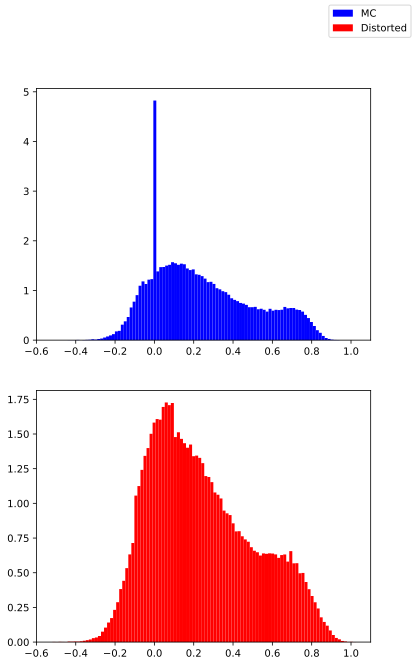

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (6,10))
ax1.hist(inputs.MC_features[:,0],bins = 100, color = 'b', label = "MC", density = True);
ax2.hist(inputs.distorted_features[:,0], bins = 100, color = 'r', label = "Distorted", density = True);
ax2.set_xlim([-0.6,1.1])
ax1.set_xlim([-0.6,1.1])

fig.legend()
fig.show()

In [18]:
inputs = GAN_Input(MC_Graphs, distortion_range = (-0.1,0.1))
# inputs.normalize()
# inputs.normalize(distorted = True)

In [19]:
# Parameters
latent_dim = inputs.num_features
n_epochs = 50
batch_size = num_samples
lr = 0.0002
b1 = 0.5
b2 = 0.999
n_cpu = 4
channels = 1
sample_interval = 400

In [20]:
# Loss function
adversarial_loss = torch.nn.BCELoss()


# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [21]:
total_count = 0
d_loss_hist = np.array([])
g_loss_hist = np.array([])
d_loss_avg = 0
g_loss_avg = 0

for epoch in range(10):
    clear_output(wait = True)
    display(f"Training epoch #{epoch}")
    for it in range(inputs.max_iter):
        # Adversarial ground truths
        valid = torch.ones(inputs.batch_size,latent_dim).to(device);
        fake = torch.zeros(inputs.batch_size,latent_dim).to(device);

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample DATA events as generator input
        z = inputs.sample(iteration = it, distorted = True).to(device)
        # Generate a batch of MC-like events
        gen_events = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_events), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()
        real_events = inputs.sample(iteration = it).to(device)
        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_events), valid)
        fake_loss = adversarial_loss(discriminator(gen_events.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        d_loss_avg += d_loss.item()
        g_loss_avg += g_loss.item()
        if(total_count % 100 == 99):
            d_loss_hist = np.append(d_loss_hist, d_loss_avg / 100)
            g_loss_hist = np.append(g_loss_hist, g_loss_avg / 100)
            d_loss_avg = 0
            g_loss_avg = 0
        total_count += 1
#         print(
#             "[Epoch %d/%d] [D loss: %f] [G loss: %f]"
#             % (epoch, n_epochs, d_loss.item(), g_loss.item()))

'Training epoch #9'

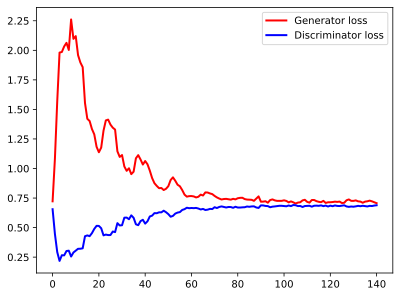

In [22]:
plt.plot(g_loss_hist,c='r',label = "Generator loss")
plt.plot(d_loss_hist,c='b',label = "Discriminator loss")
plt.legend()
plt.show()

#### Generate the GANed distribution

In [23]:
data_tensor = torch.empty_like(inputs.distorted_features)
with torch.no_grad():
    for it in range(inputs.max_iter):
        # Adversarial ground truths
        valid = torch.ones(inputs.batch_size,latent_dim).to(device);
        fake = torch.zeros(inputs.batch_size,latent_dim).to(device);

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample DATA events as generator input
        z = inputs.sample(iteration = it, distorted = True).to(device)
        # Generate a batch of MC-like events
        gen_events = generator(z)
        for i in range(inputs.batch_size):
            data_tensor[it*inputs.batch_size + i] = gen_events[i]

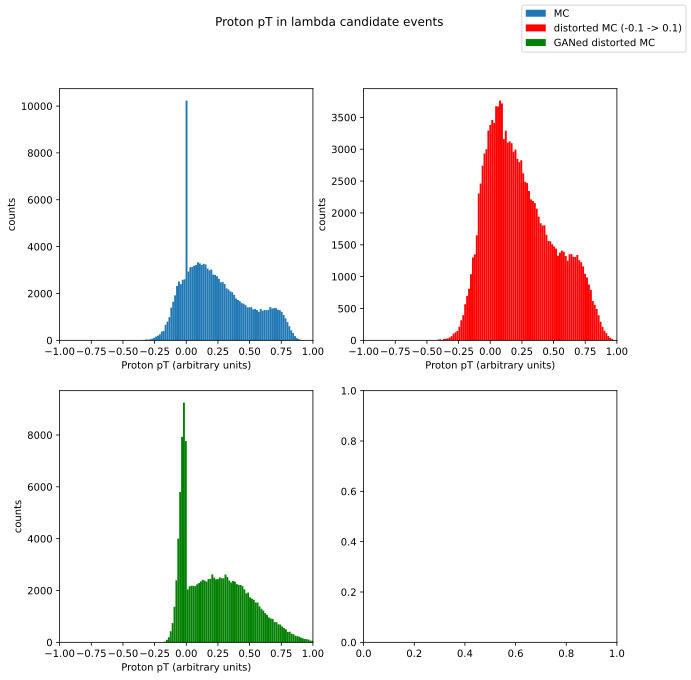

In [26]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2,figsize = (10,10))
fig.suptitle("Proton pT in lambda candidate events")

ax11.hist(inputs.MC_features[:,0], bins = 100, label = "MC");
ax11.set_xlabel("Proton pT (arbitrary units)")
ax11.set_ylabel("counts")
ax11.set_xlim([-1,1])

ax12.hist(inputs.distorted_features[:,0], bins = 100, label = "distorted MC (-0.1 -> 0.1)", color = 'r');
ax12.set_xlabel("Proton pT (arbitrary units)")
ax12.set_ylabel("counts")
ax12.set_xlim([-1,1])

ax21.hist(data_tensor[:,0], bins = 100, label = "GANed distorted MC", color = 'g');
ax21.set_xlabel("Proton pT (arbitrary units)")
ax21.set_ylabel("counts")
ax21.set_xlim([-1,1])

fig.legend()
fig.show()
fig.savefig("plots/GAN/proton_pT_distort_0_1.jpeg")

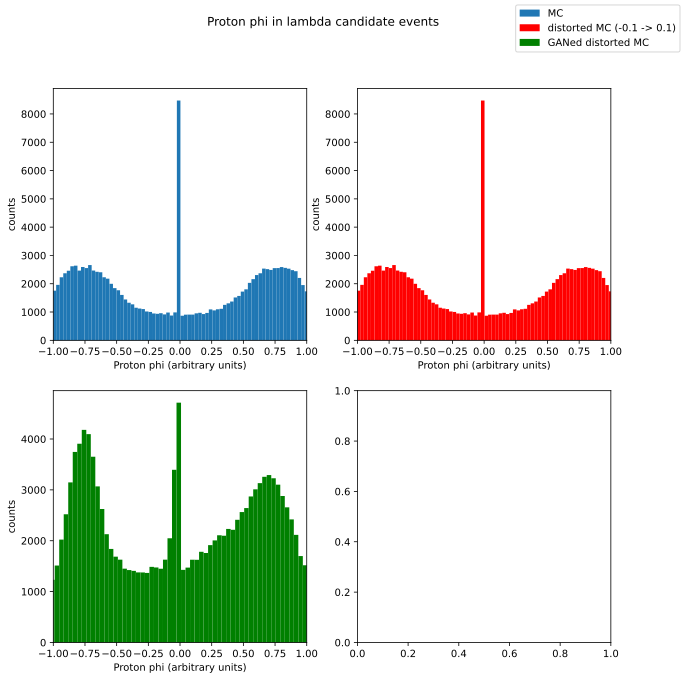

In [27]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2,figsize = (10,10))
fig.suptitle("Proton phi in lambda candidate events")

ax11.hist(inputs.MC_features[:,1], bins = 100, label = "MC");
ax11.set_xlabel("Proton phi (arbitrary units)")
ax11.set_ylabel("counts")
ax11.set_xlim([-1,1])

ax12.hist(inputs.distorted_features[:,1], bins = 100, label = "distorted MC (-0.1 -> 0.1)", color = 'r');
ax12.set_xlabel("Proton phi (arbitrary units)")
ax12.set_ylabel("counts")
ax12.set_xlim([-1,1])

ax21.hist(data_tensor[:,1], bins = 100, label = "GANed distorted MC", color = 'g');
ax21.set_xlabel("Proton phi (arbitrary units)")
ax21.set_ylabel("counts")
ax21.set_xlim([-1,1])

fig.legend()
fig.show()
fig.savefig("plots/GAN/proton_phi_distort_0_1.jpeg")